In [16]:
import os
import pandas as pd
import functools
import time
from collections import namedtuple


import numpy             as np
import tables            as tb
import pandas            as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from pylab import xticks

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  .dst_io         as dstio
import invisible_cities.reco.corrections    as corrf

from scipy.optimize import curve_fit

import invisible_cities.icaro.hst_functions as hsti
import myhst_functions as hst

In [20]:
%matplotlib inline
%load_ext autoreload
%autoreload 2



In [196]:
plt.style.available
#plt.style.use('seaborn-white')
plt.style.use('seaborn-talk')

optStat = True

default_cmap = "jet"
figure_size  = 10, 8
font_size    = 20
plt.rcParams.update({'font.size': 22})

In [18]:
import core.kr_histo_functions as krh
from invisible_cities.icaro. hst_functions import shift_to_bin_centers

In [24]:
from icaro.core.fit_functions import quick_gauss_fit
from icaro.core.fit_functions import fit_slices_2d_expo
from icaro.core.fit_functions import expo_seed
from icaro.core.fit_functions import to_relative
from icaro.core.fit_functions import conditional_labels

with_titles  = True
labels = conditional_labels(with_titles)



## Load data

- Run 4495: high radon open castle
- Run 4576: medium radon, closed castle

In [7]:
inputFolder_4576 = "/Users/jjgomezcadenas/Projects/ICDEV/data/"
inputFilename_4576 = inputFolder_4576+"4576_positions.hdf5" 
r4576 = pd.read_hdf(inputFilename_4576)
#print(datos_4576)

inputFolder_4495 = "/Users/jjgomezcadenas/Projects/ICDEV/data/"
inputFilename_4495 = inputFolder_4495+"4495_positions.hdf5" 
r4495 = pd.read_hdf(inputFilename_4495)

In [33]:
r4576.head()

,Xavg,Yavg,Zavg,centre_dist,eblob1,eblob1_bary,eblob1_vxl,eblob2,eblob2_bary,eblob2_vxl,energy,event,evt_energy,length,maxR,maxZ,minZ,numb_of_tracks,numb_of_voxels,raw_evt_energy
0,-36.514403,55.497008,534.275000,6.288641,541.849722,541.849722,541.849722,523.778209,434.953048,541.849722,541.849722,1,541.849722,14.937300,73.586758,547.025,525.025,1,4,98410.734467
1,-74.512794,-104.677762,531.421429,7.992541,211.572613,211.572613,211.572613,211.572613,211.572613,211.572613,211.572613,2,1467.279378,0.000000,148.933628,554.850,512.850,3,1,267829.084417
2,-74.512794,-104.677762,531.421429,8.821936,77.578118,144.632596,77.578118,77.578118,144.632596,77.578118,77.578118,2,1467.279378,0.000000,148.933628,554.850,512.850,3,1,267829.084417
3,-74.512794,-104.677762,531.421429,10.703731,639.686453,639.686453,639.686453,538.442194,538.442194,538.442194,1178.128647,2,1467.279378,38.367957,148.933628,554.850,512.850,3,6,267829.084417
4,105.491118,148.900964,175.434524,7.655140,469.824145,536.769650,525.594038,145.675694,109.571111,145.675694,703.406365,3,703.406365,46.867789,193.381163,193.625,165.625,1,8,138674.708061


In [139]:
Zrange  =  0,  600
XYrange = -200,  200
Erange  =  0, 3e3
Qrange  =  100, 1500
Znbins  =   10
XYnbins =   20
Enbins  =  100
Qnbins  =  100

In [10]:
Zbins     = np.linspace(* Zrange,  Znbins + 1)
Ebins     = np.linspace(* Erange,  Enbins + 1)
Qbins     = np.linspace(* Qrange,  Qnbins + 1)
XYbins    = np.linspace(*XYrange, XYnbins + 1)
XYcenters = shift_to_bin_centers(XYbins)

In [106]:
t_4495 = 55164.7589998
t_4576 = 193250.488

In [199]:
def h1d(x, bins=None, range=None, weights=None, xlabel='Variable', ylabel='Frequency',
        title=None, legend = 'upper right', figsize=(6,6)):

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)

    ax.set_xlabel(xlabel,fontsize = 20)
    ax.set_ylabel(ylabel, fontsize = 20)
    ax.hist(x,
            bins= bins,
            range=range,
            weights=weights,
            histtype='step',
            edgecolor='black',
            linewidth=1.5)
    plt.grid(True)

    if title:
        plt.title(title)


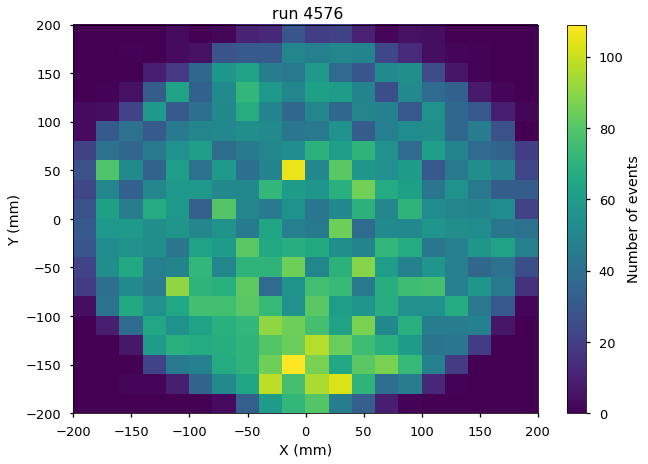

In [197]:
nevt, *_ = plt.hist2d(r4576.Xavg, r4576.Yavg, (XYbins, XYbins))
plt.colorbar().set_label("Number of events")
labels("X (mm)", "Y (mm)", f" run 4576")

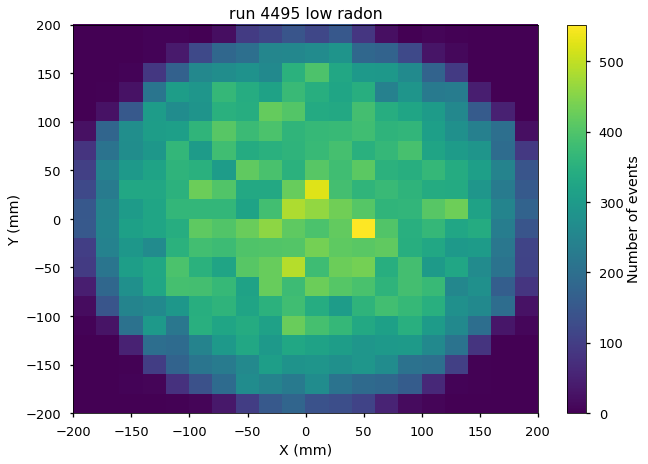

In [28]:
nevt, *_ = plt.hist2d(r4495.Xavg, r4495.Yavg, (XYbins, XYbins))
plt.colorbar().set_label("Number of events")
labels("X (mm)", "Y (mm)", f"run 4495 low radon")

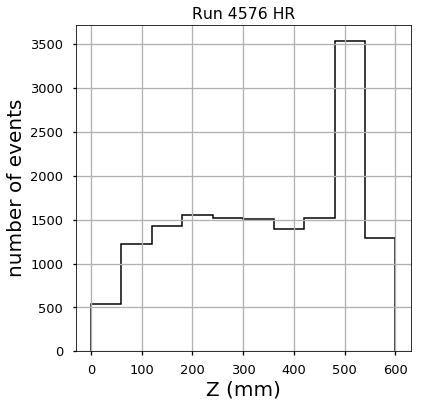

In [201]:
h1d(r4576.Zavg, bins=Znbins, range=(Zrange[0], Zrange[1]), xlabel='Z (mm)', ylabel='number of events',
        title='Run 4576 HR', legend = 'upper right', figsize=(6,6))

In [203]:
w4576 = 1e+3 * np.ones(r4576.Zavg.shape[0]) / t_4576

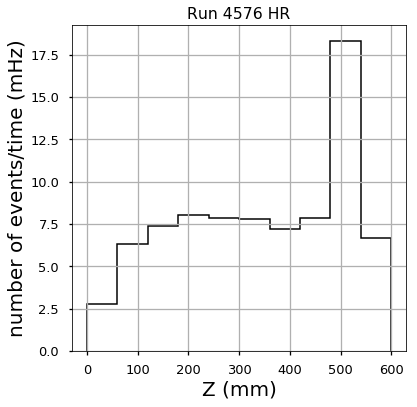

In [206]:
h1d(r4576.Zavg, bins=Znbins, range=(Zrange[0], Zrange[1]),  weights=w4576, xlabel='Z (mm)', ylabel='number of events/time (mHz)',
        title='Run 4576 HR', legend = 'upper right', figsize=(6,6))

(395.29811468689144, 224.58530250682935)

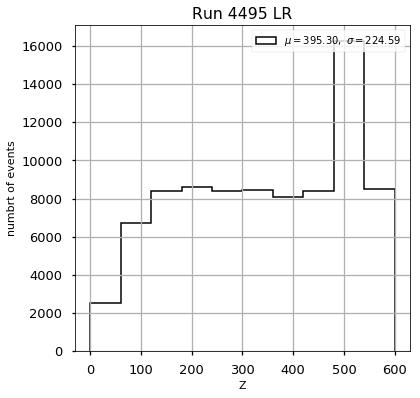

In [32]:
krh.h1d(r4495.Zavg, bins=Znbins, range=(Zrange[0], Zrange[1]), xlabel='Z', ylabel='numbrt of events',
        title='Run 4495 LR', legend = 'upper right', figsize=(6,6))

(334.35143203883501, 168.75332055147649)

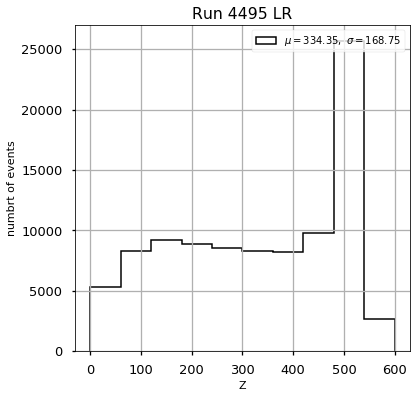

In [35]:
krh.h1d(r4495.minZ, bins=Znbins, range=(Zrange[0], Zrange[1]), xlabel='Z', ylabel='numbrt of events',
        title='Run 4495 LR', legend = 'upper right', figsize=(6,6))

(461.58641198179862, 282.16949568005145)

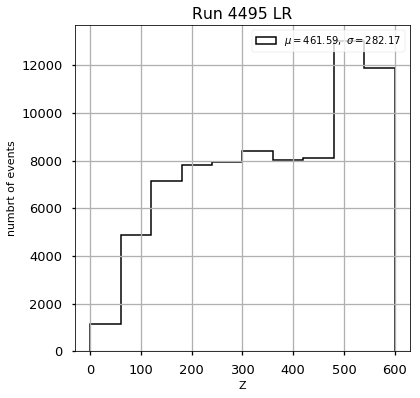

In [36]:
krh.h1d(r4495.maxZ, bins=Znbins, range=(Zrange[0], Zrange[1]), xlabel='Z', ylabel='numbrt of events',
        title='Run 4495 LR', legend = 'upper right', figsize=(6,6))

In [37]:
def R(x, y):
    return np.sqrt(x**2 + y**2)
def Dz(zmin, zmax):
    return zmax - zmin

(134.30497524475302, 230.20956324208359)

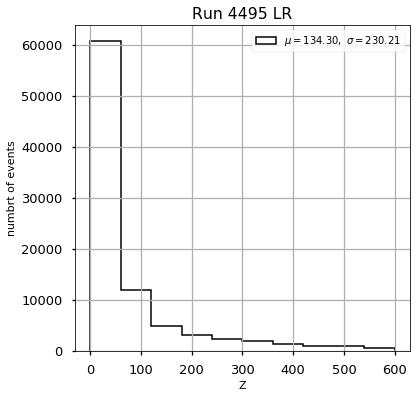

In [39]:
krh.h1d(Dz(r4495.minZ, r4495.maxZ), bins=Znbins, range=(Zrange[0], Zrange[1]), xlabel='Z', ylabel='numbrt of events',
        title='Run 4495 LR', legend = 'upper right', figsize=(6,6))

(122.18308983645103, 46.641233258456879)

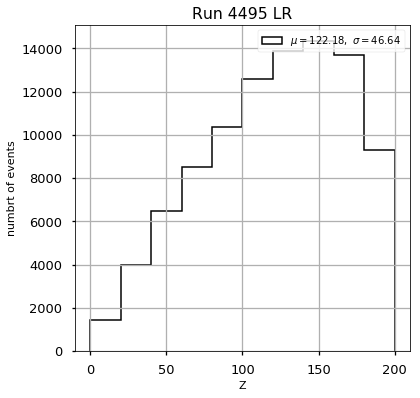

In [41]:
krh.h1d(R(r4495.Xavg, r4495.Yavg), bins=Znbins, range=(0, 200), xlabel='Z', ylabel='numbrt of events',
        title='Run 4495 LR', legend = 'upper right', figsize=(6,6))

In [133]:
fr4495 = r4495[R(r4495.Xavg, r4495.Yavg) < 180]
fr4576 = r4576[R(r4576.Xavg, r4576.Yavg) < 180]

In [134]:
fzmin4495 = fr4495[50 < fr4495.maxZ]
fzmin4576 = fr4576[50 < fr4576.maxZ]

In [135]:
f4495 = fzmin4495[fzmin4495.maxZ < 490]
f4576 = fzmin4576[fzmin4576.maxZ < 490]

(289.91827748770174, 118.72894416685021)

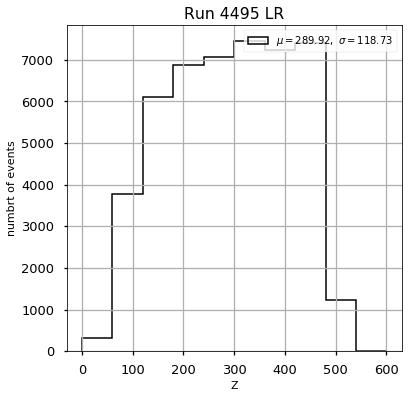

In [51]:
krh.h1d(f4495.maxZ, bins=Znbins, range=(Zrange[0], Zrange[1]), xlabel='Z', ylabel='numbrt of events',
        title='Run 4495 LR', legend = 'upper right', figsize=(6,6))

(289.21812646713613, 118.21761167746087)

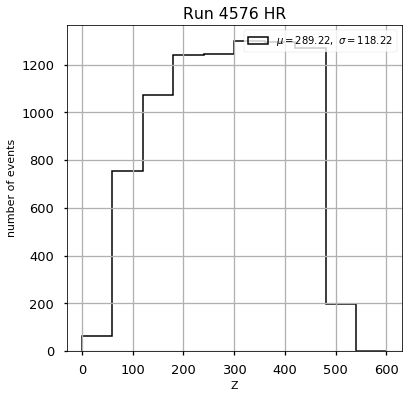

In [136]:
krh.h1d(f4576.maxZ, bins=Znbins, range=(Zrange[0], Zrange[1]), xlabel='Z', ylabel='number of events',
        title='Run 4576 HR', legend = 'upper right', figsize=(6,6))

### Number of tracks 

(1.9694639221895498, 4.2180147477231351)

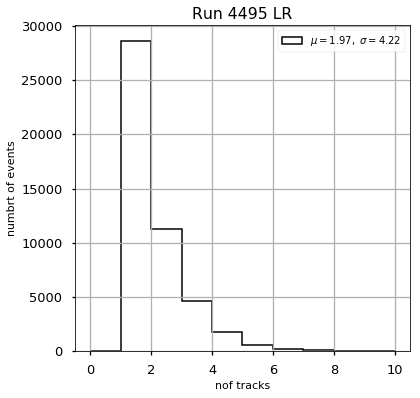

In [52]:
krh.h1d(f4495.numb_of_tracks, bins=Znbins, range=(0, 10), xlabel='nof tracks', ylabel='number of events',
        title='Run 4495 LR', legend = 'upper right', figsize=(6,6))

(1.7017543859649122, 1.1233551293741841)

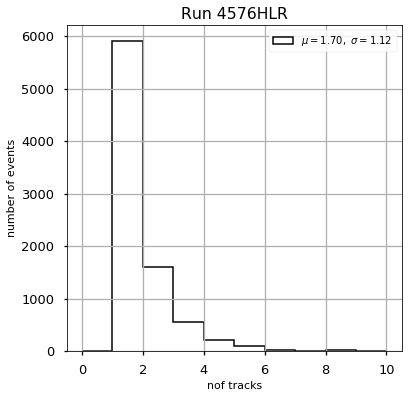

In [137]:
krh.h1d(f4576.numb_of_tracks, bins=Znbins, range=(0, 10), xlabel='nof tracks', ylabel='number of events',
        title='Run 4576HLR', legend = 'upper right', figsize=(6,6))

In [138]:
fn4495 = f4495[f4495.numb_of_tracks==1]
fn4576 = f4576[f4576.numb_of_tracks==1]

### Track length

(43.772288004948436, 29.637091983748871)

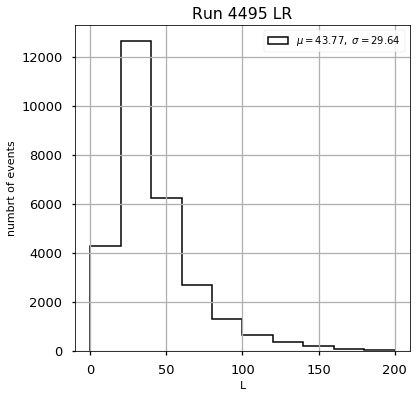

In [56]:
krh.h1d(fn4495.length, bins=Znbins, range=(Zrange[0], 200), xlabel='L', ylabel='numbrt of events',
        title='Run 4495 LR', legend = 'upper right', figsize=(6,6))

### Energy

(677.78485362720869, 282.66517203842392)

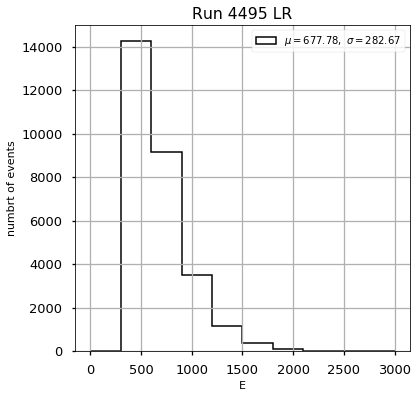

In [140]:
krh.h1d(fn4495.energy, bins=Znbins, range=(Erange[0], Erange[1]), xlabel='E', ylabel='numbrt of events',
        title='Run 4495 LR', legend = 'upper right', figsize=(6,6))

In [141]:
fl4495 = fn4495[fn4495.length<200]
fl4576= fn4576[fn4576.length<200]

In [142]:
fe4495 = fl4495[fl4495.energy<3000]
fe4576 = fl4576[fl4576.energy<3000]

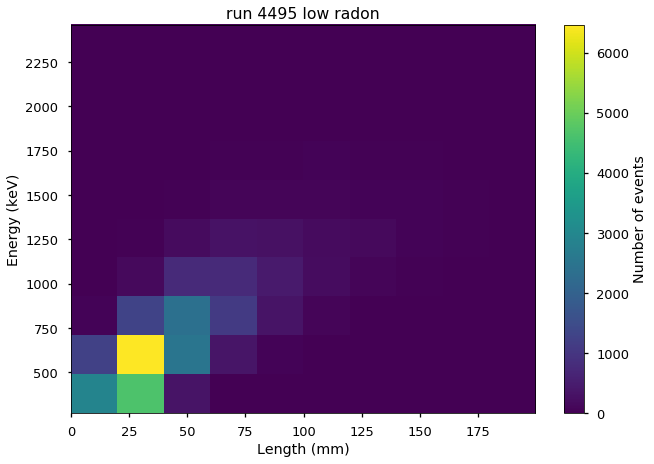

In [144]:
nevt, *_ = plt.hist2d(fe4495.length, fe4495.energy, (10, 10))
plt.colorbar().set_label("Number of events")
labels("Length (mm)", "Energy (keV)", f"run 4495 low radon")

In [145]:
fx4495 = fe4495[fe4495.energy>600]
fx4576 = fe4576[fe4576.energy>600]

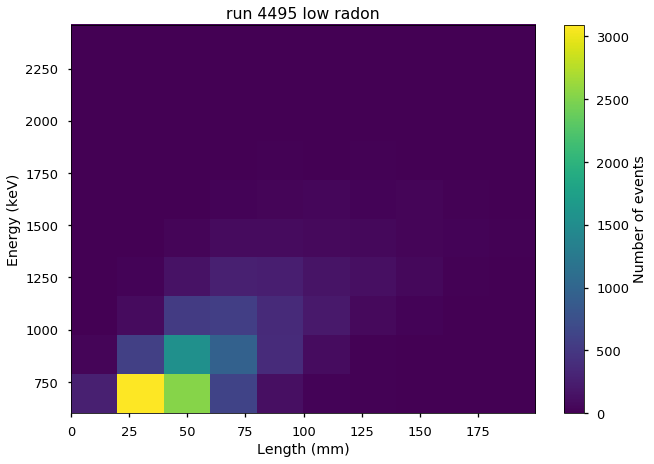

In [146]:
nevt, *_ = plt.hist2d(fx4495.length, fx4495.energy, (10, 10))
plt.colorbar().set_label("Number of events")
labels("Length (mm)", "Energy (keV)", f"run 4495 low radon")

(204.05643616510031, 156.51453372465144)

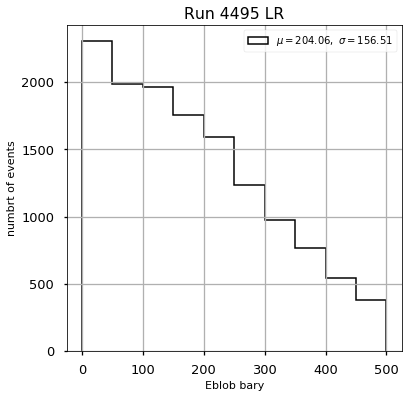

In [148]:
krh.h1d(abs(fx4495.eblob1_bary - fx4495.eblob2_bary), bins=Znbins, range=(0, 500), xlabel='Eblob bary', ylabel='numbrt of events',
        title='Run 4495 LR', legend = 'upper right', figsize=(6,6))

In [147]:
fb4495 = fx4495[abs(fx4495.eblob1_bary - fx4495.eblob2_bary)>50]
fb4576 = fx4576[abs(fx4576.eblob1_bary - fx4576.eblob2_bary)>50]

(213.10901552897477, 167.692375879803)

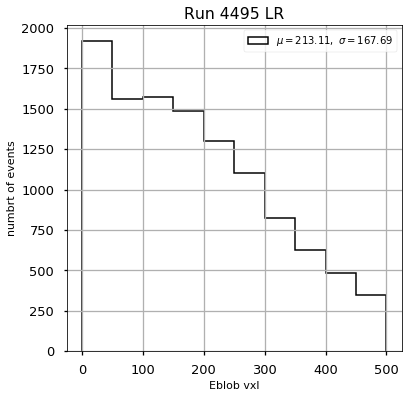

In [149]:
krh.h1d(abs(fb4495.eblob1_vxl - fb4495.eblob2_vxl), bins=Znbins, range=(0, 500), xlabel='Eblob vxl', ylabel='numbrt of events',
        title='Run 4495 LR', legend = 'upper right', figsize=(6,6))

In [151]:
fv4495 = fb4495[abs(fb4495.eblob1_vxl - fb4495.eblob2_vxl)>50]
fv4576 = fb4576[abs(fb4576.eblob1_vxl - fb4576.eblob2_vxl)>50]

(245.58747919421228, 152.08563152444273)

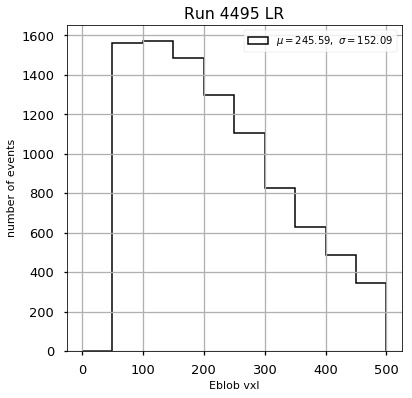

In [152]:
krh.h1d(abs(fv4495.eblob1_vxl - fv4495.eblob2_vxl), bins=Znbins, range=(0, 500), xlabel='Eblob vxl', ylabel='number of events',
        title='Run 4495 LR', legend = 'upper right', figsize=(6,6))

(452.65503048702533, 154.52653864549626)

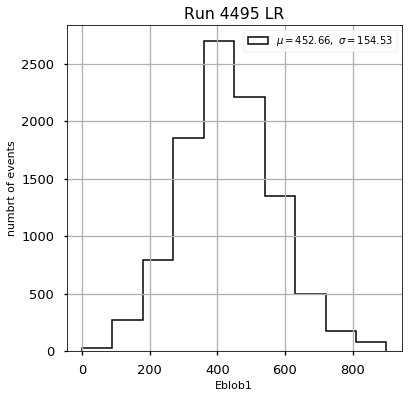

In [153]:
krh.h1d(fv4495.eblob1, bins=Znbins, range=(0, 900), xlabel='Eblob1', ylabel='numbrt of events',
        title='Run 4495 LR', legend = 'upper right', figsize=(6,6))

(229.05652758865727, 121.7042712273406)

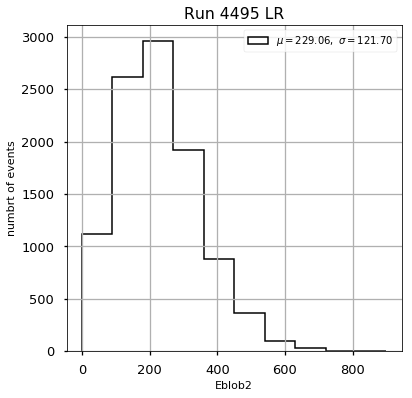

In [154]:
krh.h1d(fv4495.eblob2, bins=Znbins, range=(0, 900), xlabel='Eblob2', ylabel='numbrt of events',
        title='Run 4495 LR', legend = 'upper right', figsize=(6,6))

In [156]:
fba4495 = fv4495[fv4495.eblob1 < 800]
fba4576 = fv4576[fv4576.eblob1 < 800]

In [157]:
fbb4495 = fba4495[fba4495.eblob2 < 800]
fbb4576 = fba4576[fba4576.eblob2 < 800]

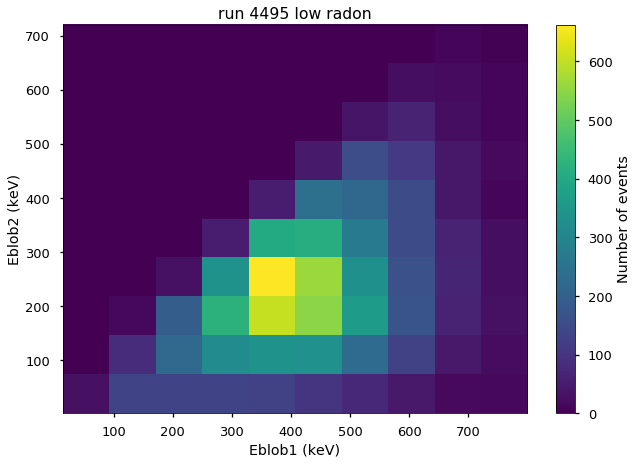

In [158]:
nevt, *_ = plt.hist2d(fbb4495.eblob1, fbb4495.eblob2, (10, 10))
plt.colorbar().set_label("Number of events")
labels("Eblob1 (keV)", "Eblob2 (keV)", f"run 4495 low radon")

In [159]:
fc4495 = fbb4495[fbb4495.eblob1 > 300]
fc4576 = fbb4576[fbb4576.eblob1 > 300]

In [160]:
fd4495 = fc4495[fc4495.eblob2 > 300]
fd4576 = fc4576[fc4576.eblob2 > 300]

In [161]:
t_4495

55164.7589998

In [162]:
t_4576

193250.488

In [163]:
w4495 = 1e+3 * np.ones(fd4495.energy.shape[0]) / t_4495

In [164]:
w4495

array([ 0.01812752,  0.01812752,  0.01812752, ...,  0.01812752,
        0.01812752,  0.01812752])

In [207]:
w4576 = 1e+3 * np.ones(fd4576.energy.shape[0]) / t_4576

(817.81808044870832, 211.40121374391109)

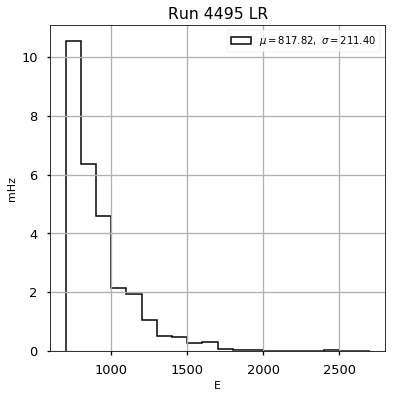

In [185]:
krh.h1d(fd4495.energy, bins=20, range=(700, 2700), weights=w4495, xlabel='E', ylabel='mHz',
        title='Run 4495 LR', legend = 'upper right', figsize=(6,6))

(826.00415221416824, 225.49790584036447)

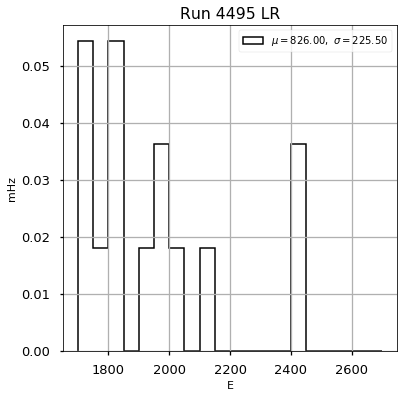

In [186]:
krh.h1d(fd4495.energy, bins=20, range=(1700, 2700), weights=w4495, xlabel='E', ylabel='mHz',
        title='Run 4495 LR', legend = 'upper right', figsize=(6,6))

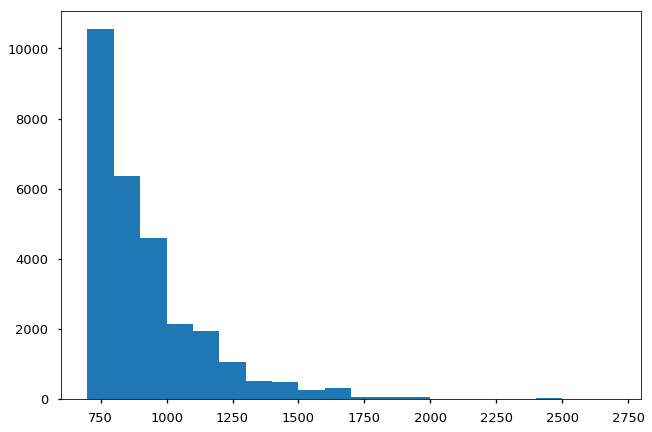

In [170]:
n,bin_edges,patches = plt.hist(fd4495.energy, bins=20, range=(700, 2700), weights=w4495*1e+3)

In [174]:
x = shift_to_bin_centers(bin_edges)

In [175]:
err = np.sqrt(n)

In [177]:
err

array([ 102.71423353,   79.76689657,   67.85564698,   46.24983003,
         44.0413909 ,   32.70356844,   22.92810365,   22.12335659,
         16.48977641,   17.55470752,    8.51528392,    7.3744522 ,
          7.3744522 ,    4.25764196,    4.25764196,    0.        ,
          0.        ,    6.021215  ,    0.        ,    0.        ])

<Container object of 3 artists>

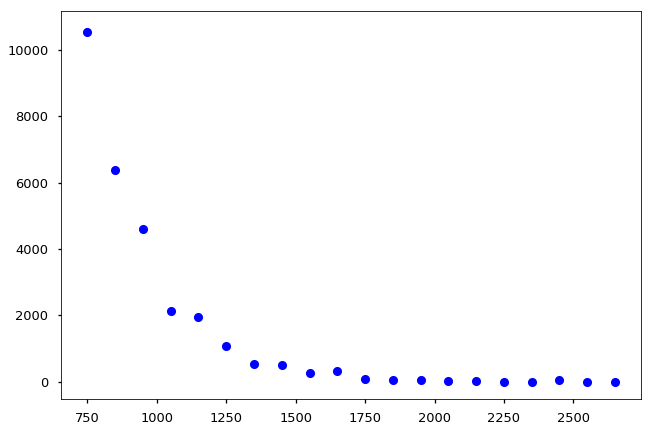

In [176]:
plt.errorbar(x,n,yerr=err,fmt='bo')

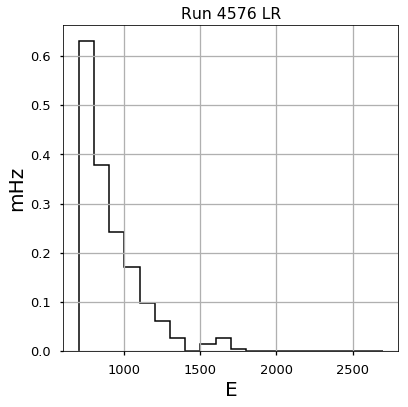

In [208]:
h1d(fd4576.energy, bins=20, range=(700, 2700), weights=w4576, xlabel='E', ylabel='mHz',
        title='Run 4576 LR', legend = 'upper right', figsize=(6,6))

(821.51856773396162, 218.59784164405013)

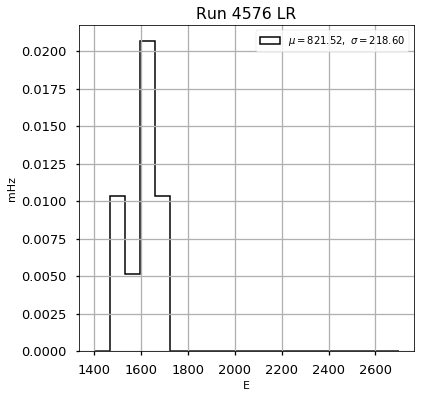

In [209]:
krh.h1d(fd4576.energy, bins=20, range=(1400, 2700), weights=w4576, xlabel='E', ylabel='mHz',
        title='Run 4576 LR', legend = 'upper right', figsize=(6,6))

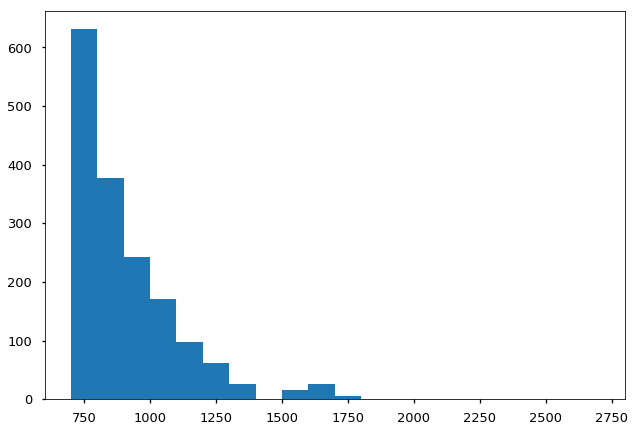

In [182]:
n,bin_edges,patches = plt.hist(fd4576.energy, bins=20, range=(700, 2700), weights=w4576*1e+3)

In [183]:
x = shift_to_bin_centers(bin_edges)
err = np.sqrt(n)

<Container object of 3 artists>

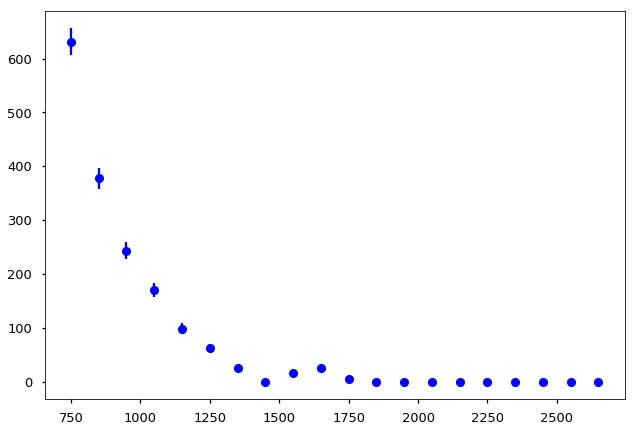

In [184]:
plt.errorbar(x,n,yerr=err,fmt='bo')